In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import os
import json
from sklearn.decomposition import PCA
from itertools import permutations
np.random.seed(42)

%matplotlib inline  
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [2]:
# Set data input folder
# Download files described in README.md to this folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

In [3]:
# Load p_values from the hit calling process
df_p_values = pd.read_csv('../Hit_Calling/outputs/HeLa_DMEM_significant_features_mann_whitney_p_values.csv.gz')
df_p_values = df_p_values.set_index('Gene')

# Load expression data 
with open("../Hit_Calling/outputs/HeLa_CCLE_expression_summary.json") as f:
    express = json.load(f)
    zero_tpm_list = express['zero_tpm']
    expressed_gene_list = express['expressed_genes']

### Load barcodes used in experiment
guides = pd.read_csv('../common_files/Barcodes.csv')
guide_list = list(guides['sgRNA'])

# Import the guide-level profiles
df_guide = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___DMEM___ALLWELLS.csv.gz")
df_guide = df_guide[df_guide["Metadata_Foci_Barcode_MatchedTo_Barcode"].isin(guide_list)]
# Subset the nontargeting guide profiles 
df_nontargeting = df_guide.query("Metadata_Foci_Barcode_MatchedTo_GeneCode == 'nontargeting'")

In [4]:
# Extract the features from the guide level profiles
feature_dict = {}
for (df_p_value,condition) in [(df_p_values,'DMEM')]:
      features = list(df_p_value.columns)[2:]
      mito_list = [feature for feature in df_p_value.columns if 'mito'  in feature.lower()]
      cona_list = [feature for feature in df_p_value.columns if 'cona'  in feature.lower()]
      dapi_list = [feature for feature in df_p_value.columns if 'dapi'  in feature.lower()]
      wga_list = [feature for feature in df_p_value.columns if 'wga'  in feature.lower()]
      phalloidin_list = [feature for feature in df_p_value.columns if 'phalloidin'  in feature.lower()]
      feature_dict[condition] = {'Mito':mito_list,'ConA':cona_list,'DAPI':dapi_list,'WGA':wga_list,'Phalloidin':phalloidin_list,'Sum':features}
      print(f'Number of features per compartment, {condition}: ','\n',
            'Mito features: ',len(mito_list),'\n',
            'ConA features: ',len(cona_list),'\n',
            'DAPI features: ',len(dapi_list),'\n',
            'WGA features: ',len(wga_list),'\n',
            'Phalloidin features: ',len(phalloidin_list))

Number of features per compartment, DMEM:  
 Mito features:  376 
 ConA features:  223 
 DAPI features:  379 
 WGA features:  287 
 Phalloidin features:  220


In [5]:
# Calculate false discovery rate (FDR)
def FDR_thresholds(control_sig_feature, fdr):
    total = len(control_sig_feature)
    fdr_length = 100/fdr
    FDR_threshold = int(total/fdr_length)
    print(FDR_threshold)
    mito_threshold, cona_threshold, wga_threshold, dapi_threshold, phal_threshold, sum_threshold = 0,0,0,0,0,0
    channels = ['Mito','ConA','WGA','DAPI','Phalloidin']
    c = 200
    feat_threshold = 0
    while feat_threshold <= FDR_threshold:
        feat_threshold = len(control_sig_feature.query('Mito > @c'))
        mito_threshold = c + 1
        c-=1    
    
    c = 200
    feat_threshold = 0
    while feat_threshold <= FDR_threshold:
        feat_threshold = len(control_sig_feature.query('ConA > @c'))
        cona_threshold = c + 1
        c-=1     
        
    c = 200
    feat_threshold = 0
    while feat_threshold <= FDR_threshold:
        feat_threshold = len(control_sig_feature.query('WGA > @c'))
        wga_threshold = c + 1
        c-=1    
    
    c = 200
    feat_threshold = 0
    while feat_threshold <= FDR_threshold:
        feat_threshold = len(control_sig_feature.query('DAPI > @c'))
        dapi_threshold = c + 1
        c-=1    
    
    c = 200
    feat_threshold = 0
    while feat_threshold <= FDR_threshold:
        feat_threshold = len(control_sig_feature.query('Phalloidin > @c'))
        phal_threshold = c + 1
        c-=1    
        
    c = 500
    feat_threshold = 0
    while feat_threshold <= FDR_threshold:
        feat_threshold = len(control_sig_feature.query('Sum > @c'))
        sum_threshold = c + 1
        c-=1    
    
    return mito_threshold, cona_threshold, wga_threshold, dapi_threshold, phal_threshold, sum_threshold

In [6]:
# Quantification of number of significant features per compartment at a certain p-value
whole_cell_hits_dict = {}
comp_spec_hits_dict = {}
non_hits_dict = {}
threshold_dict = {}
for (df_p_values, condition,fdr_value) in [(df_p_values,'DMEM_1',1),(df_p_values,'DMEM_2',2),(df_p_values,'DMEM_3',3),(df_p_values,'DMEM_4',4),(df_p_values,'DMEM_5',5)]:
    p_value = 0.001
    gene_list = list(df_p_values.index)

    df_sig_feature = pd.DataFrame(index=gene_list)
    for gene in gene_list:
        for channel in feature_dict['DMEM'].keys():
            count = 0
            for feat in feature_dict['DMEM'][channel]:
                if df_p_values.loc[gene,feat]<p_value:
                    count += 1
            df_sig_feature.loc[gene,channel] = count
        
    df_sig_feature = df_sig_feature.drop(index = 'sig_gene_count')
    # Perturbations divided into 2 groups of controls with 0 TPM and others
    df_sig_feature_zero_tpm = df_sig_feature.loc[zero_tpm_list]
    df_sig_feature_expressed = df_sig_feature.loc[expressed_gene_list]

    # Compute and print the threshold for FDR calculations at 5% from the 0 TPM gene perturbations
    mito_threshold, cona_threshold, wga_threshold, dapi_threshold, phal_threshold,sum_threshold = FDR_thresholds(df_sig_feature_zero_tpm,fdr_value)
    threshold_dict[condition] = {'Mito':mito_threshold, 'ConA':cona_threshold, 'WGA':wga_threshold, 'DAPI':dapi_threshold, 'Phalloidin':phal_threshold,'Sum':sum_threshold}
    print(f'For HeLa {condition} \n'
        'Mito genes', mito_threshold, '\n', 
        'ConA genes', cona_threshold, '\n', 
        'WGA genes', wga_threshold, '\n', 
        'DAPI genes', dapi_threshold, '\n', 
        'Phalloidin genes', phal_threshold, '\n',
        'Whole Profile genes', sum_threshold)
    # Save the number of significant features per channel for whole cell hits and compartment hits
    whole_cell_hits = df_sig_feature_expressed.query('Sum > @sum_threshold')
    comp_spec_hits = df_sig_feature_expressed.query('Sum <= @sum_threshold').query('Phalloidin > @phal_threshold | DAPI > @dapi_threshold | WGA > @wga_threshold | ConA > @cona_threshold | Mito > @mito_threshold')
    whole_cell_hits = whole_cell_hits.reset_index().rename(columns={'index':'Gene'})
    comp_spec_hits = comp_spec_hits.reset_index().rename(columns={'index':'Gene'})
    whole_cell_hits.to_csv(os.path.join(output_folder,f'HeLa_{condition}_plate_level_median_per_feat_sig_genes_FDR_whole_cell_hits.csv'),index=False)
    comp_spec_hits.to_csv(os.path.join(output_folder,f'HeLa_{condition}_plate_level_median_per_feat_sig_genes_FDR_compartment_specific_hits.csv'),index=False)
    
    # Create lists for follow up steps
    hit_list = list(comp_spec_hits.Gene) + list(whole_cell_hits.Gene)
    whole_cell_hit_list = list(whole_cell_hits.Gene)
    comp_spec_hit_list = list(comp_spec_hits.Gene)
    all_genes_list = list(df_guide.Metadata_Foci_Barcode_MatchedTo_GeneCode.unique())
    all_genes_list.remove("nontargeting")
    non_hit_list = [gene for gene in all_genes_list if gene not in hit_list]

    whole_cell_hits_dict[condition] = whole_cell_hit_list
    comp_spec_hits_dict[condition] = comp_spec_hit_list
    non_hits_dict[condition] = non_hit_list


34
For HeLa DMEM_1 
Mito genes 64 
 ConA genes 52 
 WGA genes 72 
 DAPI genes 60 
 Phalloidin genes 61 
 Whole Profile genes 221
69
For HeLa DMEM_2 
Mito genes 56 
 ConA genes 38 
 WGA genes 58 
 DAPI genes 51 
 Phalloidin genes 52 
 Whole Profile genes 198
104
For HeLa DMEM_3 
Mito genes 50 
 ConA genes 34 
 WGA genes 50 
 DAPI genes 48 
 Phalloidin genes 47 
 Whole Profile genes 181
138
For HeLa DMEM_4 
Mito genes 46 
 ConA genes 31 
 WGA genes 44 
 DAPI genes 43 
 Phalloidin genes 43 
 Whole Profile genes 170
173
For HeLa DMEM_5 
Mito genes 43 
 ConA genes 29 
 WGA genes 40 
 DAPI genes 41 
 Phalloidin genes 40 
 Whole Profile genes 164


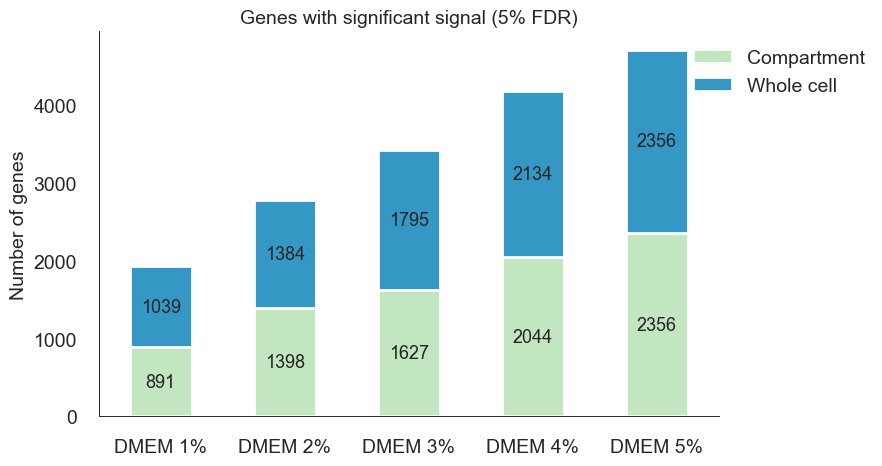

In [7]:
# Plot hits summary for Fig 3A
mpl.rc('axes', linewidth=0.7)
mpl.rc('xtick', labelsize=14)
mpl.rc('xtick', labelsize=14)

fig, ax = plt.subplots(figsize=(8,5))
colors = sns.color_palette('GnBu')[:8]
hits_plot = pd.DataFrame({'Compartment':[len(comp_spec_hits_dict['DMEM_1']),len(comp_spec_hits_dict['DMEM_2']),len(comp_spec_hits_dict['DMEM_3']),len(comp_spec_hits_dict['DMEM_4']),len(comp_spec_hits_dict['DMEM_5'])],
                         'Whole cell':[len(whole_cell_hits_dict['DMEM_1']),len(whole_cell_hits_dict['DMEM_2']),len(whole_cell_hits_dict['DMEM_3']),len(whole_cell_hits_dict['DMEM_4']),len(whole_cell_hits_dict['DMEM_5'])]},
                        index=['DMEM 1%','DMEM 2%','DMEM 3%','DMEM 4%','DMEM 5%'])

hits_plot.plot(kind='bar', 
               stacked=True,
               color=[colors[1], colors[4]],
               legend = 'reverse',
               rot = 0,
               fontsize= 14,
               width = 0.5,
               ax=ax)

ax.set_title('Genes with significant signal (5% FDR)',size=14) #Genes with significant signal above noise
ax.set_ylabel('Number of genes',size=14)

ax.bar_label(ax.containers[0],label_type='center',size=13)
ax.bar_label(ax.containers[1],label_type='center',size=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc="upper left", bbox_to_anchor=(0.93,1),frameon=False, ncol=1, fontsize =14)
fig.savefig(os.path.join(output_folder,'figure_panels','Fig3A_HeLa_DMEM_HPLM_whole_cell_compartment_specific_hits.png'),dpi = 300,bbox_inches='tight')

In [4]:
# Run this cell if you are starting from this point
'''
whole_cell_hits_dict = {}
comp_spec_hits_dict = {}
non_hits_dict = {}
conditions = ['DMEM_1','DMEM_2','DMEM_3','DMEM_4','DMEM_5']
for condition in conditions:
    whole_cell_hits = pd.read_csv(f'inputs/HeLa_{condition}_plate_level_median_per_feat_sig_genes_fdr_whole_cell_hits.csv')
    comp_spec_hits = pd.read_csv(f'inputs/HeLa_{condition}_plate_level_median_per_feat_sig_genes_fdr_compartment_specific_hits.csv')
    all_hits = pd.concat([whole_cell_hits,comp_spec_hits])
    hit_list = list(comp_spec_hits.Gene) + list(whole_cell_hits.Gene)
    whole_cell_hit_list = list(whole_cell_hits.Gene)
    comp_spec_hit_list = list(comp_spec_hits.Gene)
    all_genes_list = list(df_guide.Metadata_Foci_Barcode_MatchedTo_GeneCode.unique())
    all_genes_list.remove("nontargeting")
    non_hit_list = [gene for gene in all_genes_list if gene not in hit_list]

    whole_cell_hits_dict[condition] = whole_cell_hit_list
    comp_spec_hits_dict[condition] = comp_spec_hit_list
    non_hits_dict[condition] = non_hit_list
    
    print(f'for condition {condition} there are {len(whole_cell_hit_list)} Whole cell hits')
    print(f'for condition {condition} there are {len(comp_spec_hit_list)} Compartment hits')
    print(f'for condition {condition} there are {len(non_hit_list)} Compartment hits')
'''

for condition DMEM_1 there are 1039 Whole cell hits
for condition DMEM_1 there are 891 Compartment hits
for condition DMEM_1 there are 18463 Compartment hits
for condition DMEM_2 there are 1384 Whole cell hits
for condition DMEM_2 there are 1398 Compartment hits
for condition DMEM_2 there are 17611 Compartment hits
for condition DMEM_3 there are 1795 Whole cell hits
for condition DMEM_3 there are 1627 Compartment hits
for condition DMEM_3 there are 16971 Compartment hits
for condition DMEM_4 there are 2134 Whole cell hits
for condition DMEM_4 there are 2044 Compartment hits
for condition DMEM_4 there are 16215 Compartment hits
for condition DMEM_5 there are 2356 Whole cell hits
for condition DMEM_5 there are 2356 Compartment hits
for condition DMEM_5 there are 15681 Compartment hits


In [9]:
gene_list = list(df_guide.Metadata_Foci_Barcode_MatchedTo_GeneCode)
df_temp = df_guide.drop('Metadata_Foci_Barcode_MatchedTo_GeneCode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_Barcode')
# Perform principal component analysis on hit list
pca = PCA()
pca.fit(df_temp)
x = list(pca.explained_variance_ratio_)
# Find principal component that represents 90% variation
PCA_lookup = {}
for i in range(len(x)):
    distance = abs(.9-sum(x[:i+1]))
    PCA_lookup[distance] = i 
component = PCA_lookup[min(PCA_lookup.keys())]+1
print (f'Principal component representing closest to 90% variation is {component}')
# Perform principal component analysis and select components representing 90% of variation in data
pca = PCA(n_components=component)
df_guide_pca = pd.DataFrame(pca.fit_transform(df_temp),index=df_temp.index)
df_guide_pca_updated = df_guide_pca.reset_index()
pca_feat_list = list(df_guide_pca_updated.columns)
feat_list = ['Metadata_Foci_Barcode_MatchedTo_GeneCode']
feat_list.extend(pca_feat_list)
df_guide_pca_updated["Metadata_Foci_Barcode_MatchedTo_GeneCode"] = gene_list
df_guide_pca_updated = df_guide_pca_updated[feat_list]
df_guide_pca_updated

Principal component representing closest to 90% variation is 721


,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,0,1,2,3,4,5,6,7,...,711,712,713,714,715,716,717,718,719,720
0,A1BG,CAAGAGAAAGACCACGAGCA,-2.797839,-6.638351,3.732794,-5.500276,3.400353,-2.234676,1.326102,5.053755,...,0.241482,-0.171463,-0.625455,-0.250776,-0.353409,-0.138890,-0.085550,0.329036,-0.284652,0.206191
1,A1BG,CATCTTCTTTCACCTGAACG,4.223268,2.547329,-0.519613,-2.526660,-1.950841,-0.214483,2.180046,1.034041,...,0.086648,-0.118261,0.196763,0.162544,0.017518,-0.268122,-0.489097,-0.091617,0.196780,-0.114386
2,A1BG,CTCCGGGGAGAACTCCGGCG,0.226131,7.664180,1.334145,0.852733,0.490193,-1.142523,-3.919489,2.274953,...,0.576608,-0.058459,-0.066772,-0.077361,-0.006004,0.420932,-0.402277,0.014008,0.195629,0.164378
3,A1BG,TGGAAGTCCACTCCACTCAG,4.121460,6.407549,4.803152,-0.593453,-3.772468,1.283582,-2.047281,0.690167,...,-0.027847,0.002095,-0.048349,0.098467,-0.356540,-0.048950,-0.228383,-0.020243,0.058803,0.082844
4,A1CF,AGTTATGTTAGGTATACCCG,-0.356097,7.524270,-0.444434,-1.801940,-0.231022,1.885177,-0.823700,5.150096,...,-0.249216,0.522745,0.192456,0.431842,0.407669,-0.401520,-0.170310,-0.396645,0.125855,-0.547748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80797,nontargeting,TTTATGCATTTAATACGCCG,1.344141,1.089012,1.373800,-1.499881,-0.343863,-0.275255,-0.552219,0.419090,...,-0.088031,-0.014674,0.015220,0.017975,-0.025242,0.024487,0.052627,0.019017,0.026286,-0.033297
80798,nontargeting,TTTCTAGTTACTACTGGACG,0.748472,1.479106,0.429455,-2.093931,0.316832,-0.384918,-0.124140,0.508944,...,-0.032442,-0.004506,0.007683,0.046887,-0.124274,0.053902,-0.040933,0.025015,-0.040172,-0.031332
80799,nontargeting,TTTGGCAGTACCTTTTATTA,-0.086137,0.508386,0.346766,-2.673848,0.279349,0.144354,-0.572088,0.527859,...,0.006255,0.047129,-0.005670,-0.012268,-0.014207,0.042112,-0.064304,0.016314,-0.000536,0.034016
80800,nontargeting,TTTTACCTTGTTCACATGGA,-0.894496,1.648901,-0.633126,-1.322831,-0.078447,0.129657,-0.132439,0.788267,...,-0.038093,-0.002455,-0.009004,-0.017090,-0.027939,0.019961,0.013012,-0.028242,-0.024118,-0.019193


In [10]:
def cosine_to_df(df_temp, cosine_array, i):
    cosine_list = cosine_array[i]
    gene_list = list(df_temp.index)
    cosine_df = pd.DataFrame(index=gene_list)
    cosine_df['cosine'] = cosine_list
    cosine_df = cosine_df.sort_values('cosine',ascending=False)   
    return cosine_df

def ap_from_cosine_df(cosine_df,gene,n=10):    
    #print(cosine_df.iloc[:20])
    index_list = list(cosine_df.index)
    boolean = [1 if  i == gene else 0 for i in index_list ]
    grades_list=[]
    for i in range(2,n+2):
        pre_grade = sum(boolean[1:i])/(i-1)
        grades_list.append(pre_grade*boolean[i-1])
    return sum(grades_list)/3

def calculate_map(df_guide, gene):
    df_temp = df_guide.query("Metadata_Foci_Barcode_MatchedTo_GeneCode == 'nontargeting' | Metadata_Foci_Barcode_MatchedTo_GeneCode == @gene")
    df_temp = df_temp.drop(['Metadata_Foci_Barcode_MatchedTo_Barcode'],axis=1)
    df_temp = df_temp.set_index("Metadata_Foci_Barcode_MatchedTo_GeneCode")
    ap_list = []
    cosine_array = cosine_similarity(df_temp)
    for guide in range(4):
        cosine_df = cosine_to_df(df_temp, cosine_array, guide)
        guide_ap = ap_from_cosine_df(cosine_df,gene,10)
        ap_list.append(guide_ap)
    return np.mean(ap_list)

In [11]:
# Plot hits summary for Fig 3A
import matplotlib as mpl
def plot_results(plot_dict,group):
    mpl.rc('axes', linewidth=0.7)
    mpl.rc('xtick', labelsize=14)
    mpl.rc('xtick', labelsize=14)
    
    fig, ax = plt.subplots(figsize=(7,5))
    colors = sns.color_palette('GnBu')[:8]
    hits_plot = pd.DataFrame({'Average_mAP':list(plot_dict.values())},
                             index = ['DMEM 1%','DMEM 2%','DMEM 3%','DMEM 4%','DMEM 5%'])
    
    hits_plot.plot(kind='bar', 
                   stacked=True,
                   color=[colors[5]],
                   legend = 'reverse',
                   rot = 0,
                   fontsize= 14,
                   width = 0.5,
                   ax=ax)
    
    ax.set_title('',size=14) #Genes with significant signal above noise
    ax.set_ylabel('Average mAP',size=14)
    
    ax.bar_label(ax.containers[0],label_type='center',size=12,fmt='%0.2f',color="midnightblue")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc="upper left", bbox_to_anchor=(0.8,1),frameon=False, ncol=1, fontsize =14)
    fig.savefig(os.path.join(output_folder,'figure_panels',f'HeLa_DMEM_average_mAP_{group}.png'),dpi = 300,bbox_inches='tight')
    plt.show()


for condition DMEM_1 average mAP for Whole cell hits = 0.4448321671733606
for condition DMEM_2 average mAP for Whole cell hits = 0.3816476138865951
for condition DMEM_3 average mAP for Whole cell hits = 0.3258756871674699
for condition DMEM_4 average mAP for Whole cell hits = 0.2934833422591155
for condition DMEM_5 average mAP for Whole cell hits = 0.27557582632656913


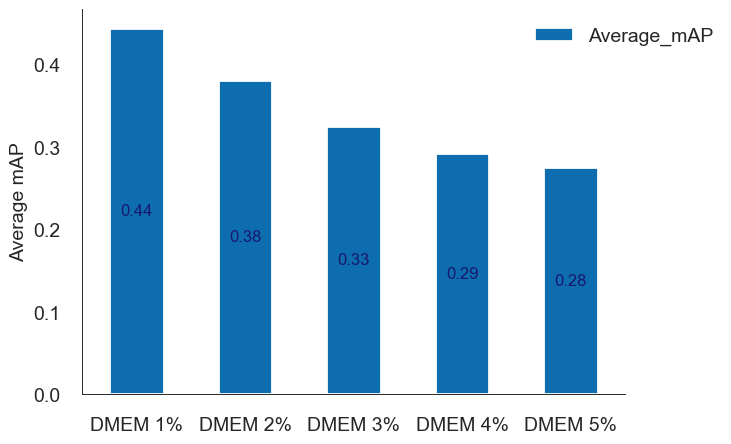

In [12]:
# calculate mAP for Whole cell hits
conditions = ['DMEM_1','DMEM_2','DMEM_3','DMEM_4','DMEM_5']

plot_whole_cell_hits_dict = {}
for condition in conditions:
    whole_cell_hit_list = whole_cell_hits_dict[condition]
    map_list = []
    for gene in whole_cell_hit_list:
        gene_map = calculate_map(df_guide_pca_updated, gene)
        map_list.append(gene_map)
    plot_whole_cell_hits_dict[condition] = np.mean(map_list)
    print(f'for condition {condition} average mAP for Whole cell hits = {np.mean(map_list)}')
plot_results(plot_whole_cell_hits_dict,'whole_cell_hits')

for condition DMEM_1 average mAP for Compartment hits = 0.13873364004536842
for condition DMEM_2 average mAP for Compartment hits = 0.09736568586264581
for condition DMEM_3 average mAP for Compartment hits = 0.07927758021872958
for condition DMEM_4 average mAP for Compartment hits = 0.06507447918284513
for condition DMEM_5 average mAP for Compartment hits = 0.058045623691846106


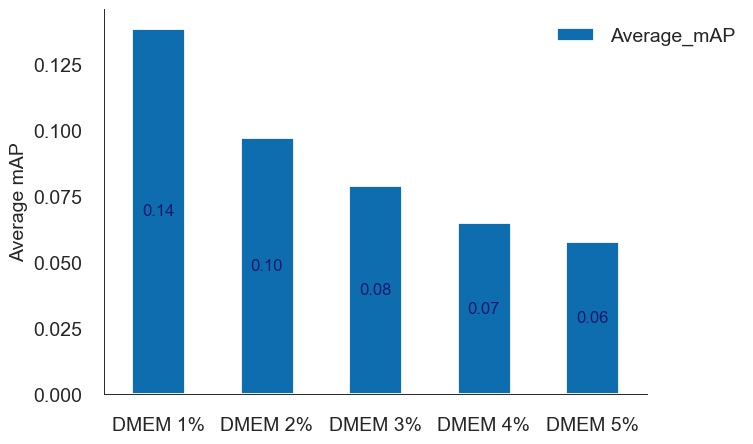

In [13]:
# calculate mAP for Compartment hits
plot_comp_spec_hits_dict = {}
for condition in conditions:
    comp_spec_hit_list = comp_spec_hits_dict[condition]
    map_list = []
    for gene in comp_spec_hit_list:
        gene_map = calculate_map(df_guide_pca_updated, gene)
        map_list.append(gene_map)
    plot_comp_spec_hits_dict[condition] = np.mean(map_list)
    print(f'for condition {condition} average mAP for Compartment hits = {np.mean(map_list)}')
plot_results(plot_comp_spec_hits_dict,'compartment_hits')

for condition DMEM_1 average mAP for non-hits = 0.02949752465033026
for condition DMEM_2 average mAP for non-hits = 0.026465707009117375
for condition DMEM_3 average mAP for non-hits = 0.024540310595198348
for condition DMEM_4 average mAP for non-hits = 0.022886179757132582
for condition DMEM_5 average mAP for non-hits = 0.021962435836311862


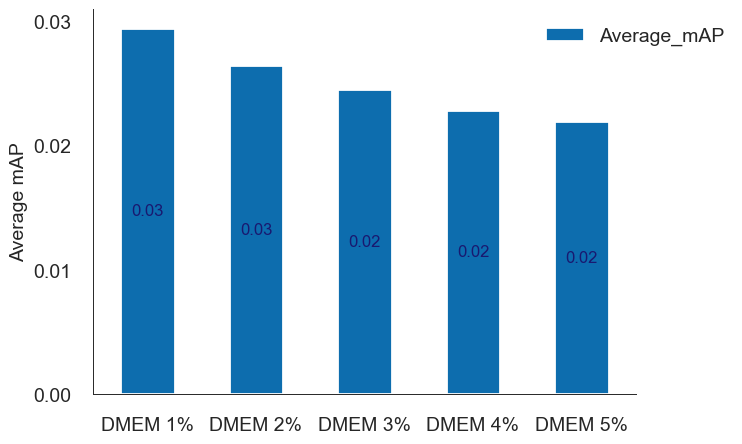

In [14]:
# calculate mAP for non_hits
plot_non_hits_dict = {}
for condition in conditions:
    non_hit_list = non_hits_dict[condition]
    map_list = []
    for gene in non_hit_list:
        gene_map = calculate_map(df_guide_pca_updated, gene)
        map_list.append(gene_map)
    plot_non_hits_dict[condition] = np.mean(map_list)
    print(f'for condition {condition} average mAP for non-hits = {np.mean(map_list)}')
plot_results(plot_non_hits_dict,'non_hits')

for condition DMEM_1 average mAP for non-hits = 0.3035193238204896
for condition DMEM_2 average mAP for non-hits = 0.23879134667686072
for condition DMEM_3 average mAP for non-hits = 0.20862988938675675
for condition DMEM_4 average mAP for non-hits = 0.18173903490442503
for condition DMEM_5 average mAP for non-hits = 0.1668107250092076


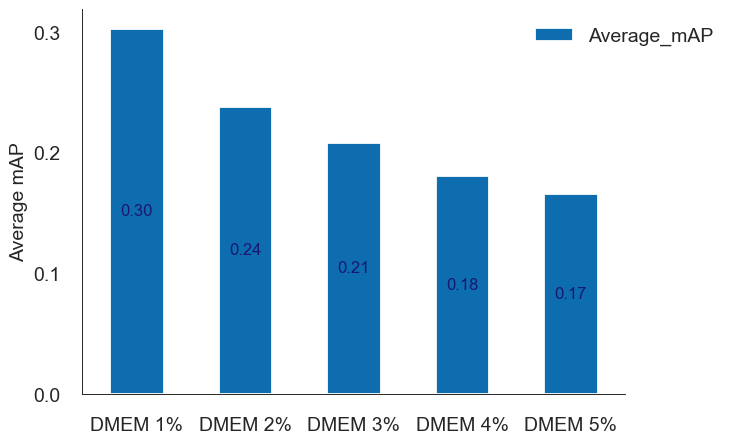

In [15]:
# calculate mAP for non_hits
plot_all_hits_dict = {}
for condition in conditions:
    all_hits_list = whole_cell_hits_dict[condition] + comp_spec_hits_dict[condition]
    map_list = []
    for gene in all_hits_list:
        gene_map = calculate_map(df_guide_pca_updated, gene)
        map_list.append(gene_map)
    plot_all_hits_dict[condition] = np.mean(map_list)
    print(f'for condition {condition} average mAP for non-hits = {np.mean(map_list)}')
plot_results(plot_all_hits_dict,'all_hits')